In [1]:
%run Latex_macros.ipynb
%run beautify_plots.py

<IPython.core.display.Latex object>

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Common imports
import os

import svm_helper
%aimport svm_helper
svmh = svm_helper.SVM_Helper()

import class_helper
%aimport class_helper

clh = class_helper.Classification_Helper()

%matplotlib inline


# Support Vector Classifier: Loss function

In concept, the SVC is quite similar to the Logistic Regression model.

The main difference between the two is the Loss function
- Cross Entropy for Logistic Regression
- Hinge Loss for the Support Vector Classifier

It is the Hinge Loss that makes this model quite interesting.

## Hinge Loss function

The Hinge Loss function is best described by a plot.

Here are the two sides of the per-example Hinge Loss

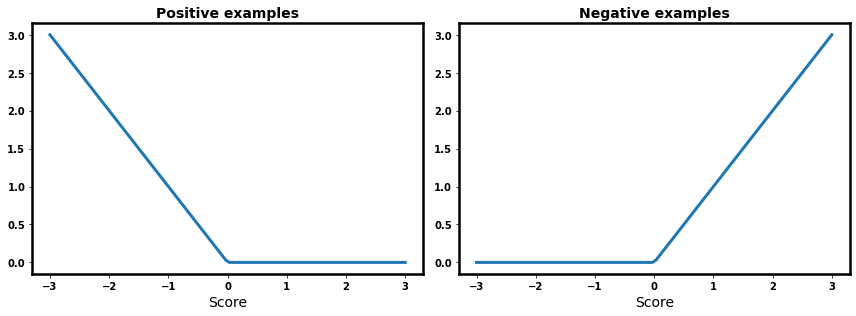

In [4]:
svmh.plot_hinges()

That is: it is a function of a "score" $\hat{s}$
- for Positive examples: the loss is $\max{}(0, - \hat{s})$
- for Negative examples: the loss is $\max{}(0,   \hat{s})$

The plot resembles a *hinge*.

The similarity between 
- the two-side Hinge Loss and 
- the two-side loss of Cross Entropy (used in Logistic Regression)

becomes more apparent if we plot them together
- Note: the horizontal scale for the Cross Entropy plots are $\hat{p}$ rather than $\hat{s}$

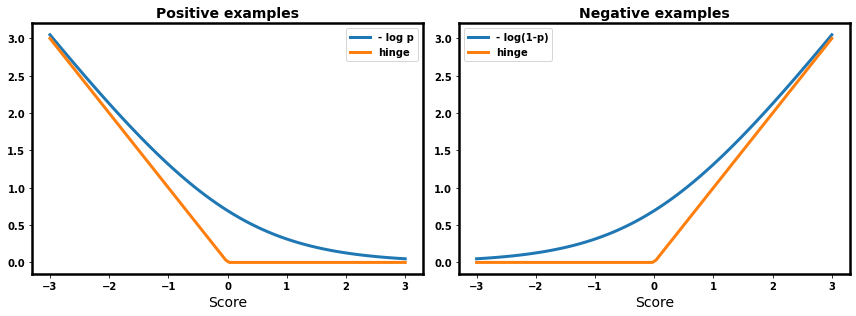

In [5]:
svmh.plot_log_p(x_axis="Score", hinge_pt=0)

## SVC Loss versus Binary Cross Entropy

For Binary Logistic Regression
- We computed a score $s$ as a linear function of the features
- We converted the linear score into a probability via the logistic function

$$ \hat{p}^\ip  = \sigma(s(\hat\x^\ip))$$

By encoding the Positive labels $\y^\ip$ with the number $1$ and Negative labels with the number $0$
- We were able to combine the two sides (Positive, Negative) of the per-example loss into a single equation

$$
\loss^\ip = - \left( \y^\ip*\log(\hat{p}^\ip) + (1-\y^\ip) * \log(1-\hat{p}^\ip) \right)
$$

This is the equation for per-example Binary Cross Entropy Loss.

For the Binary SVC:
- We compute a score as linear function of the features
- We use Hinge Loss instead of Log Loss

By analogy with Cross Entropy, we can combine the two sides (Positive, Negative) of the per-example loss into a single equation
$$
\loss^\ip = \left( \y^\ip \max{} (0, - s(\hat\x))  + (1 - \y^\ip) \max{}(0, s(\hat\x)) \right)
$$

You can see the similarity with Cross Entropy.

For SVC loss
- We can eliminate the asymmetry in the two sides
- With a slightly different encoding of Positive/Negative
- Into integers +1 and -1 (rather than +1 and 0)

To make this unusual encoding clear, we will place a "dot" over $\y$
$$
\transy^\ip = 
\left\{
    {
    \begin{array}{lll}
     +1  & \textrm{if Positive }  \y^\ip   \\
     -1  & \textrm{if Negative }  \y^\ip   \\
    \end{array}
    }
\right.
$$
This allows us to simplify the per-example SVC loss to
$$
\loss^\ip = \max{} (0,  - \transy^\ip * s(\hat\x)) 
$$

This is the equation for per-example Hinge Loss, when the "hinge point" is 0.

# Hinge Loss interpretation

From the previous plot of Cross Entropy Loss (log p) versus Hinge Loss, we can see the similarity.

The key difference is that
- A correctly classified example has a per-example Hinge Loss of 0
- A correctly classified example has a positive per-example Log Loss

An optimizer seeking the $\Theta$ that minimizes Average Loss will be sensitive to non-zero per-example loss.
- Using Log Loss: once an example is correctly classified, the example contributes to Average Loss
- Using Hinge Loss: once an example is correctly classified, the example *does not* contribute to Average Loss.

Let's see this effect in practice.

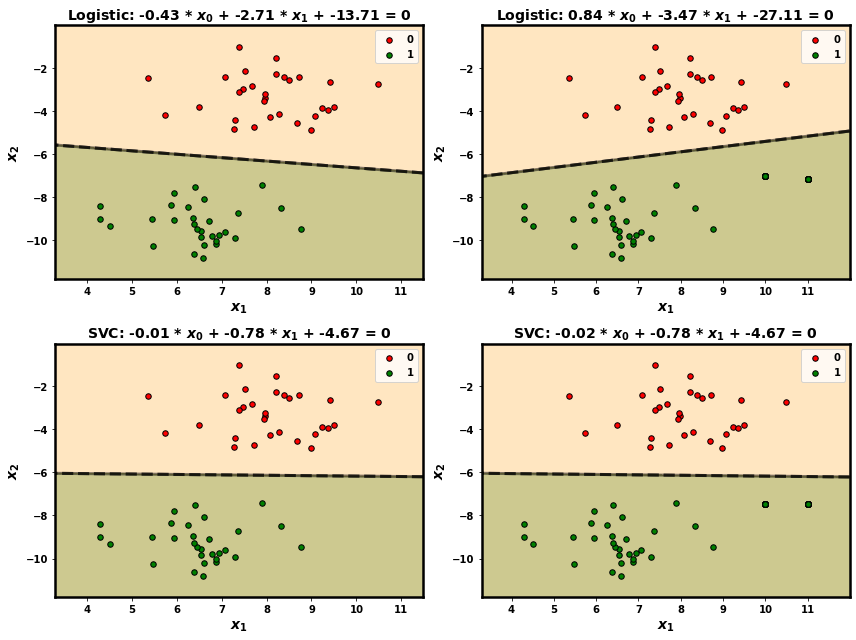

In [6]:
svm_ch = svm_helper.Charts_Helper()
_= svm_ch.create_data()
fig, axs = svm_ch.create_sens()


The chart compares Logistic Regression to SVC on an original and augmented set of examples
- The original examples are the plots on the left
- The original examples are augmented by a cluster of examples and plotted on the right
    - The new examples are correctly classified and located just below the boundary near the right edge
    - Although hard to see: there are *many* instances of each added example (all identical)

The additional examples are relatively close to the separating boundary.
- For Logistic Regression: 
    - Each example incurs a relatively high Log Loss $\loss^\ip$ since it is close to the boundary
    - There are a lot of such examples, each contributing a positive amount to Average Loss
    $$
    \loss = \frac{1}{m} \sum_{i=1}^m { \loss^\ip }
    $$
    - Minimizing Average Loss when these new examples are present means moving the boundary away from them
    

For SVC:
- The additional examples are on the correct side of the boundary and incur zero Hinge Loss
- Hence the additional examples do not affect the fit.

The key difference
- One the Hinge Loss for an example reaches $0$
- There is no benefit (i.e., reduction of Average Loss)
- To improving the parameters to make the example be "further" from the boundary

For Cross Entropy Loss
- There is always benefit until per example loss reaches 0
- Hence, in the absence of other constraints, the optimizer will try to "improve" the fit


For a Classification task
- Cross Entropy Loss continues to try to improve the probability $\hat{p}^\ip$ long after $\hat{p}^\ip$ has crossed the prediction threshold (e.g., 0.5)
    - This might lead to overfitting (high variance)
- Hinge Loss will not try to improve prediction once we cross the threshold
    - this might lead to a fit that is "good" but not "best" (high bias)

More formally: let 
- $\langle \X, \y \rangle$ denote the training dataset used in the graph on the left
- $\langle \X', \y' \rangle$ denote the set of *additional* training examples added to $\langle \X, \y \rangle$ in the graph on the right


The total loss for the graph on the right is
$$
\loss = \sum_{i=1}^{\| \X \|} \loss^\ip (\X^\ip, \y^\ip) + \sum_{i=1}^{\| \X' \|} \loss^\ip (\X'^\ip, \y'^\ip)
$$

The increase in total loss resulting from the additional training examples is
$$
\sum_{i=1}^{\| \X' \|} \loss^\ip (\X'^\ip, \y'^\ip) \ge 0
$$

Using Log Loss
- the per-example loss $\loss^\ip$ is positive for each example in the sum above
- so the total increase accumulates the $\| \X' \|$ additional positive per-example losses
- potentially forcing the optimizer to shift the separating boundary to account for the increase in total loss

Using Hinge Loss
- the per-example loss $\loss^\ip$  equals $0$ (since additional example $i$ in $\X'$ is correctly classified by the original separating boundary)
- hence, the total loss is unchanged
    - and so is the separating boundary


In [7]:
print("Done")

Done
